In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from keras_unet.utils import get_augmented
from keras_unet.models import custom_unet
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_unet.losses import jaccard_distance
from keras_unet.metrics import iou,iou_thresholded,jaccard_coef,dice_coef
from keras_unet.utils import plot_segm_history
from tensorflow.keras.losses import MeanSquaredError

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Model based on Old Data Utlizing rooms and lobby masks

In [2]:
# Getting All folders in Directory of Masks of old Data
cwd=os.getcwd()
datadir=os.path.join(os.path.dirname(cwd),'Data','updated_masks')
output = [dI for dI in os.listdir(datadir) if os.path.isdir(os.path.join(datadir,dI))]

In [3]:
# Transforming all images and their respective masks into numpy arrays
imgs_list = []
masks_list = []
room_masks=0
lobby_masks=0
furniture_masks=0
wall_masks=0
for folder in output:
    currentfolder=os.path.join(datadir,folder)
    onlyfiles = [f for f in os.listdir(currentfolder) if os.path.isfile(os.path.join(currentfolder, f))]
    flagroom=False
    flaglobby=False
    flagwall=False
    flagfurniture=False
    for file in onlyfiles:
        if 'real' in file:
            currentfile=os.path.join(currentfolder, file)
            image=np.array(Image.open(currentfile).convert('RGB').resize((384,384)))
            imgs_list.append(image)
        if 'room' in file:
            currentfile=os.path.join(currentfolder, file)
            room=np.array(Image.open(currentfile).resize((384,384)))
            room = room[:, :, 3]
            flagroom=True
        if 'lobby' in file:
            currentfile=os.path.join(currentfolder, file)
            lobby=np.array(Image.open(currentfile).resize((384,384)))
            lobby = lobby[:, :, 3]
            flaglobby=True
        if 'wall' in file:
            currentfile=os.path.join(currentfolder, file)
            wall=np.array(Image.open(currentfile).resize((384,384)))
            wall = wall[:, :, 3]
            flagwall=True
    mask=np.zeros((384,384,3))
    mask[:,:,0]=image[:,:,0]
    if flagroom:
        mask[:,:,0]=room
        room_masks+=1
    else:
        mask[:,:,0]=0
    if flaglobby:
        mask[:,:,1]=lobby
        lobby_masks+=1
    else:
        mask[:,:,1]=0
    if flagwall:
        mask[:,:,2]=wall
        wall_masks+=1
    else:
        mask[:,:,2]=0
    masks_list.append(mask)
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

print("Room Masks :",room_masks)
print("Lobby Masks :",lobby_masks)
print("Wall Masks :",wall_masks)


Room Masks : 50
Lobby Masks : 77
Wall Masks : 77


In [4]:
# Seperating masks for Visualization
masks_room=masks_np[:,:,:,0]
masks_lobby=masks_np[:,:,:,1]
masks_wall=masks_np[:,:,:,2]
masks_room=np.expand_dims(masks_room, axis=3)
masks_lobby=np.expand_dims(masks_lobby, axis=3)
masks_wall=np.expand_dims(masks_wall, axis=3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


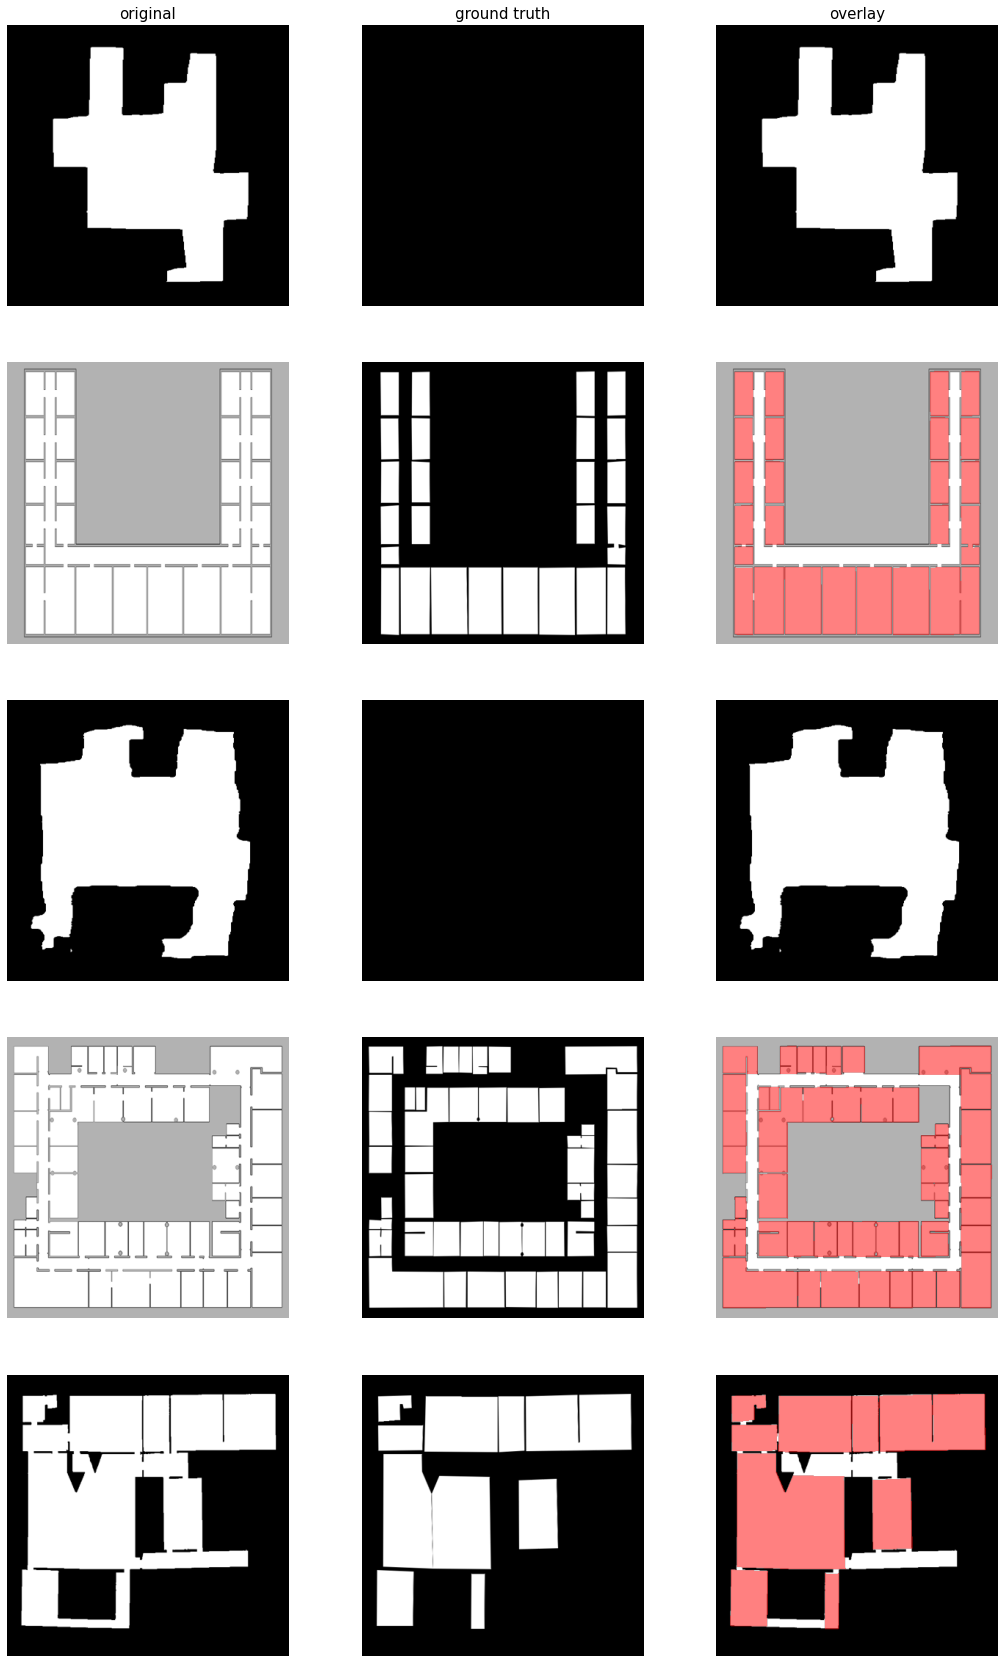

In [5]:
#Visualize Masks
plot_imgs(org_imgs=imgs_np, mask_imgs=masks_room, nm_img_to_plot=5, figsize=6)

In [5]:
# Normalizing images and their masks where images will be input i.e. x and Masks will be output i.e. y
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

print(x.max(), y.max())

1.0 1.0


In [6]:
# Splitting Data into Training and Testing
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (69, 384, 384, 3)
y_train:  (69, 384, 384, 3)
x_val:  (8, 384, 384, 3)
y_val:  (8, 384, 384, 3)


In [7]:
# Prepare Training generator for Augmenting the data
train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [9]:
# Generate a sample from Training Generator
sample_batch = next(train_gen)
xx, yy = sample_batch


masks_room_augmented=yy[:,:,:,0]
masks_lobby_augmented=yy[:,:,:,1]
masks_wall_augmented=yy[:,:,:,2]
masks_room_augmented=np.expand_dims(masks_room_augmented, axis=3)
masks_lobby_augmented=np.expand_dims(masks_lobby_augmented, axis=3)
masks_wall_augmented=np.expand_dims(masks_wall_augmented, axis=3)


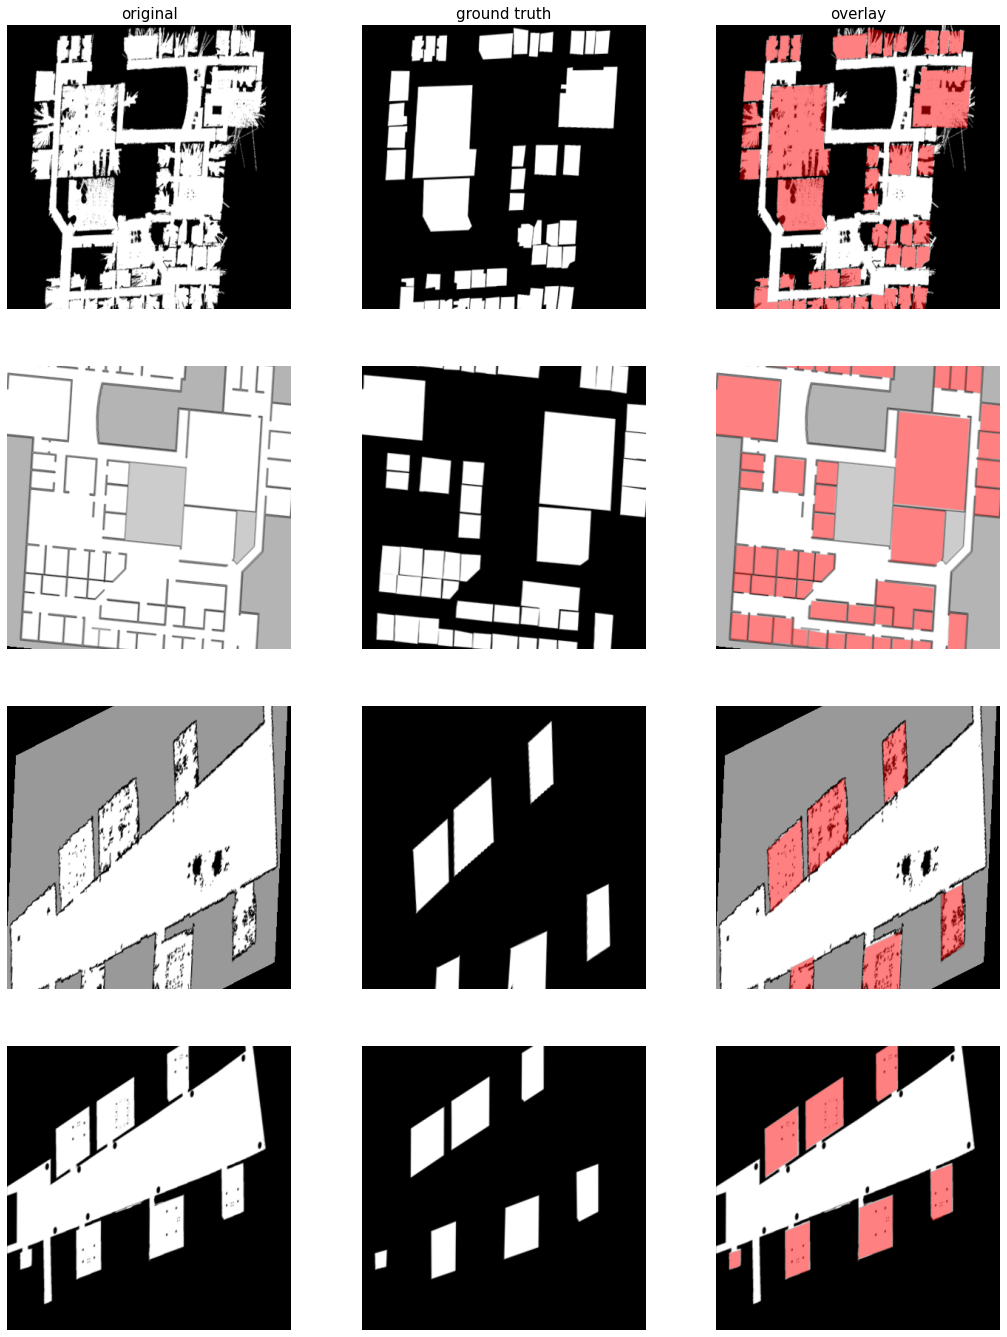

In [10]:
# Visualizing the generated output
plot_imgs(org_imgs=xx, mask_imgs=masks_room_augmented, nm_img_to_plot=4, figsize=6)

In [7]:
# Model Definition
input_shape = x[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_classes=3,
    num_layers=2
)


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 384, 384, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# Define Model Checkpoint
model_filename = 'segm_model_data_mse_loss.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True
)

In [10]:
# Compile Model
model.compile(
    optimizer=Adam(), 
    loss=MeanSquaredError(),
    metrics=[iou]
)

In [12]:
# Needed for Tensorflow Version 2.0.0
train_gen = (pair for pair in train_gen)

In [13]:
# Train Model
history = model.fit(
    train_gen,
    validation_data=(x_val, y_val),
    steps_per_epoch=50,
    epochs=10,
    callbacks=[callback_checkpoint]
)

Train for 50 steps, validate on 8 samples
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.1787 - iou: 0.2595
Epoch 00001: val_loss improved from inf to 0.34638, saving model to segm_model_data_mse_loss.h5
50/50 [==============================] - 34s 677ms/step - loss: 0.1776 - iou: 0.2606 - val_loss: 0.3464 - val_iou: 0.2252
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.1307 - iou: 0.2946
Epoch 00002: val_loss improved from 0.34638 to 0.23724, saving model to segm_model_data_mse_loss.h5
50/50 [==============================] - 29s 571ms/step - loss: 0.1303 - iou: 0.2952 - val_loss: 0.2372 - val_iou: 0.1994
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.1116 - iou: 0.3162
Epoch 00003: val_loss improved from 0.23724 to 0.15611, saving model to segm_model_data_mse_loss.h5
50/50 [==============================] - 29s 575ms/step - loss: 0.1112 - iou: 0.3160 - val_loss: 0.1561 - val_iou: 0.2466
Epoch 4/10
49/50 [===========

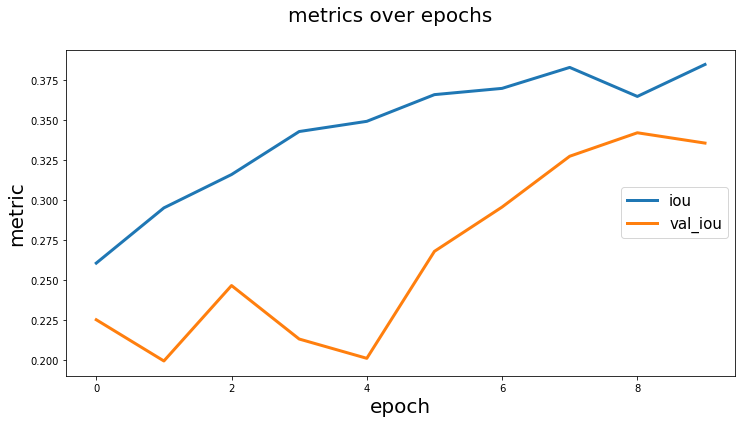

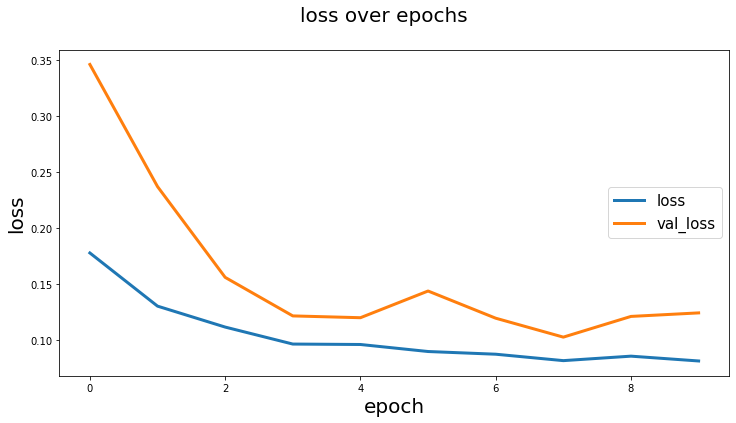

In [14]:
# Plot training history
plot_segm_history(history)

In [11]:
# Predict on validation set
model.load_weights(model_filename)
y_pred = model.predict(x_val)

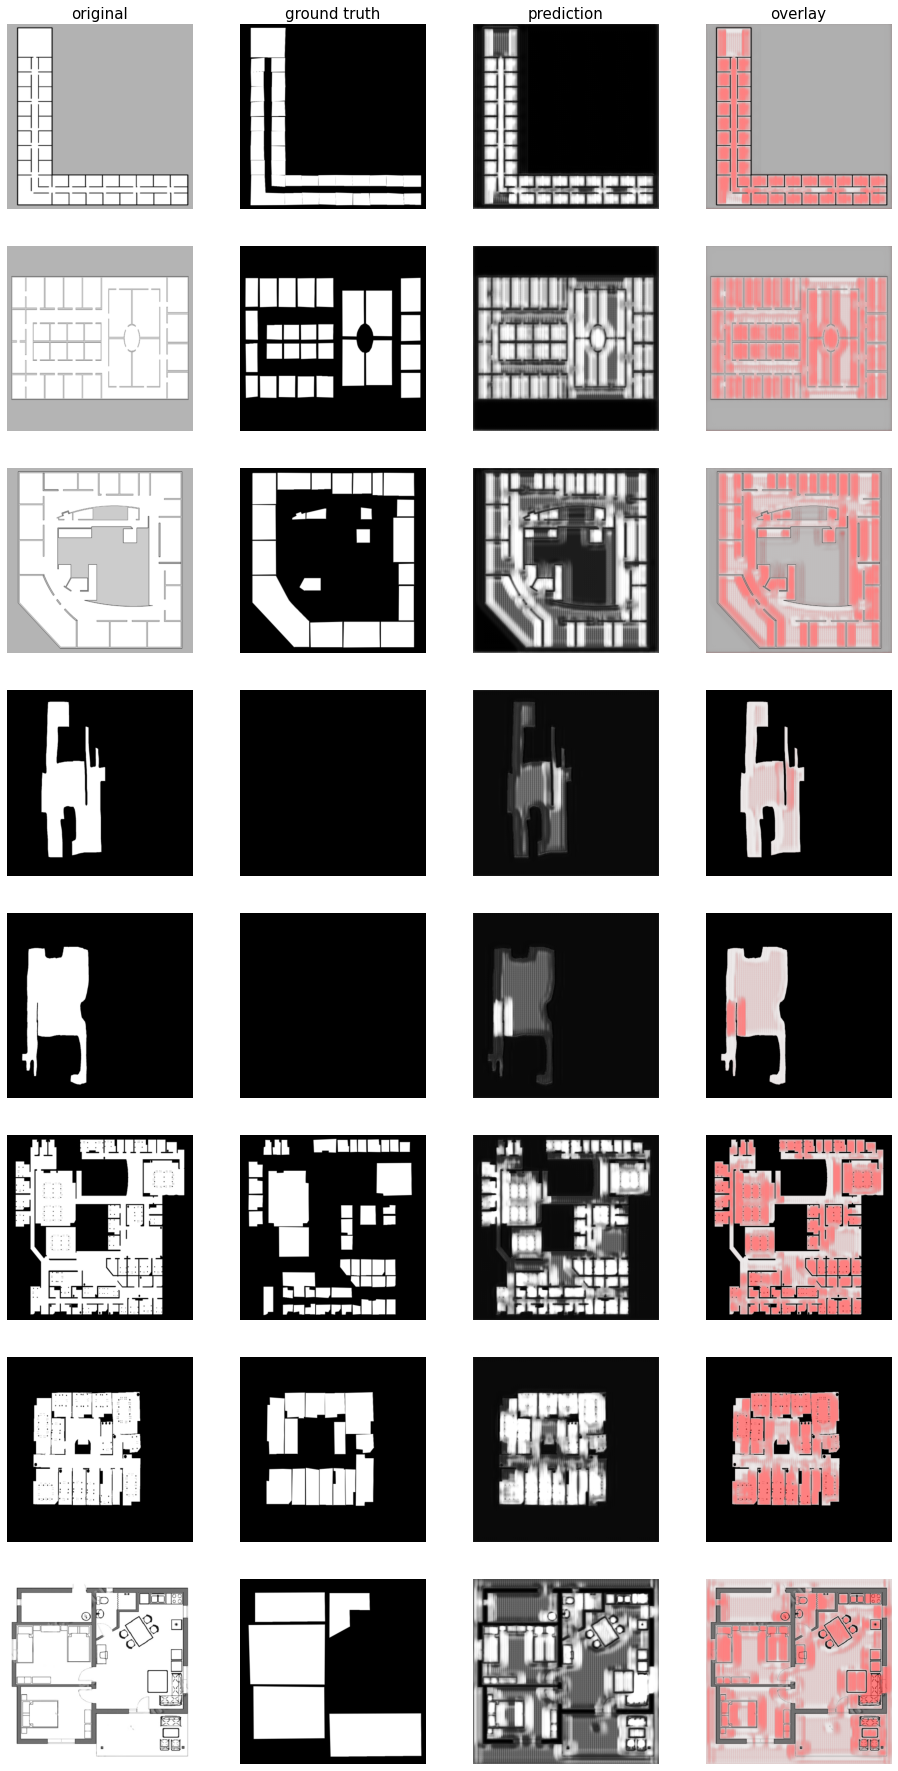

In [14]:
# Visualize Prediction
plot_imgs(org_imgs=x_val, mask_imgs=y_val[:,:,:,0], pred_imgs=y_pred[:,:,:,0], nm_img_to_plot=8)

# Model based on New Data of Flat maps

In [15]:
# Getting All folders in Directory of Data
cwd=os.getcwd()
datadir=os.path.join(os.path.dirname(cwd),'Data_new','mask')
output = [dI for dI in os.listdir(datadir) if os.path.isdir(os.path.join(datadir,dI))]

In [17]:
# Transforming all images and their respective masks into numpy arrays
imgs_list = []
masks_list = []
bathroom_masks=0
furniture_masks=0
hall_masks=0
kitchen_masks=0
room_masks=0
terrace_masks=0
window_masks=0

for folder in output:
    currentfolder=os.path.join(datadir,folder)
    onlyfiles = [f for f in os.listdir(currentfolder) if os.path.isfile(os.path.join(currentfolder, f))]
#     print(folder,len(onlyfiles))
    flagbathroom=False
    flagfurniture=False
    flaghall=False
    flagkitchen=False
    flagroom=False
    flagterrace=False
    flagwindow=False
    for file in onlyfiles:
        if 'Bathroom' in file:
            currentfile=os.path.join(currentfolder, file)
            bathroom=np.array(Image.open(currentfile).resize((384,384)))
            bathroom = bathroom[:, :, 3]
            flagbathroom=True
        elif 'Furniture' in file:
            currentfile=os.path.join(currentfolder, file)
            furniture=np.array(Image.open(currentfile).resize((384,384)))
            furniture = furniture[:, :, 3]
            flagfurniture=True
        elif 'Hall' in file:
            currentfile=os.path.join(currentfolder, file)
            hall=np.array(Image.open(currentfile).resize((384,384)))
            hall = hall[:, :, 3]
            flaghall=True
        elif 'Kitchen' in file:
            currentfile=os.path.join(currentfolder, file)
            kitchen=np.array(Image.open(currentfile).resize((384,384)))
            kitchen = kitchen[:, :, 3]
            flagkitchen=True
        elif 'Room' in file:
            currentfile=os.path.join(currentfolder, file)
            room=np.array(Image.open(currentfile).resize((384,384)))
            room = room[:, :, 3]
            flagroom=True
        elif 'Terrace' in file:
            currentfile=os.path.join(currentfolder, file)
            terrace=np.array(Image.open(currentfile).resize((384,384)))
            terrace = terrace[:, :, 3]
            flagterrace=True
        elif 'Window' in file:
            currentfile=os.path.join(currentfolder, file)
            window=np.array(Image.open(currentfile).resize((384,384)))
            window = window[:, :, 3]
            flagwindow=True
        elif 'Other Area' in file:
            continue
        else:
            currentfile=os.path.join(currentfolder, file)
            image=np.array(Image.open(currentfile).convert('RGB').resize((384,384)))
#             print(currentfile)
            imgs_list.append(image)
    mask=np.zeros((384,384,7))
    #print(mask.shape)
    if flagbathroom:
        mask[:,:,0]=bathroom
        bathroom_masks+=1
    else:
        mask[:,:,0]=0
    if flagfurniture:
        mask[:,:,1]=furniture
        furniture_masks+=1
    else:
        mask[:,:,1]=0
    if flaghall:
        mask[:,:,2]=hall
        hall_masks+=1
    else:
        mask[:,:,2]=0
    if flagkitchen:
        mask[:,:,3]=kitchen
        kitchen_masks+=1
    else:
        mask[:,:,3]=0
    if flagroom:
        mask[:,:,4]=room
        room_masks+=1
    else:
        mask[:,:,4]=0
    if flagterrace:
        mask[:,:,5]=terrace
        terrace_masks+=1
    else:
        mask[:,:,5]=0
    if flagwindow:
        mask[:,:,6]=window
        window_masks+=1
    else:
        mask[:,:,6]=0
    masks_list.append(mask)
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

print("Bathoom Masks :",bathroom_masks)
print("Furniture Masks :",furniture_masks)
print("Hall Masks :",hall_masks)
print("kithcen Masks :",kitchen_masks)
print("Room Masks :",room_masks)
print("Terrace Masks :",terrace_masks)
print("Window Masks :",window_masks)

Bathoom Masks : 50
Furniture Masks : 50
Hall Masks : 50
kithcen Masks : 50
Room Masks : 50
Terrace Masks : 25
Window Masks : 50


In [20]:
# Seperating masks for Visualization
masks_bathroom=masks_np[:,:,:,0]
masks_furniture=masks_np[:,:,:,1]
masks_hall=masks_np[:,:,:,2]
masks_kitchen=masks_np[:,:,:,3]
masks_room=masks_np[:,:,:,4]
masks_terrace=masks_np[:,:,:,5]
masks_window=masks_np[:,:,:,6]
masks_bathroom=np.expand_dims(masks_bathroom, axis=3)
masks_furniture=np.expand_dims(masks_furniture, axis=3)
masks_hall=np.expand_dims(masks_hall, axis=3)
masks_kitchen=np.expand_dims(masks_kitchen, axis=3)
masks_room=np.expand_dims(masks_room, axis=3)
masks_terrace=np.expand_dims(masks_terrace, axis=3)
masks_window=np.expand_dims(masks_window, axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


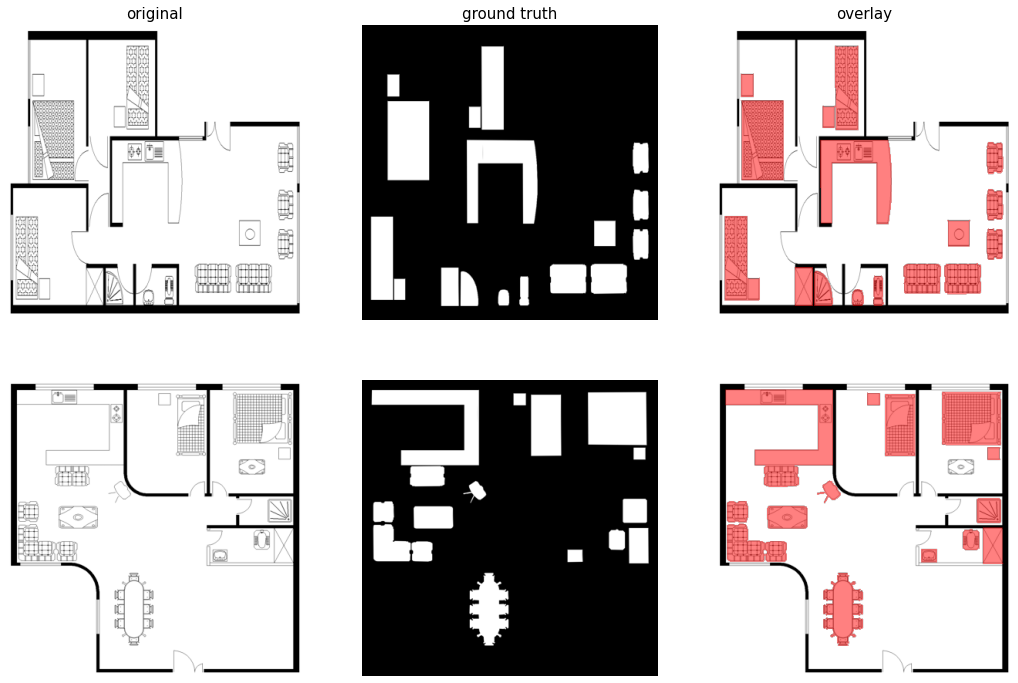

In [21]:
#Visualize Masks
plot_imgs(org_imgs=imgs_np, mask_imgs=masks_furniture, nm_img_to_plot=2, figsize=6)

In [18]:
# Normalizing images and their masks where images will be input i.e. x and Masks will be output i.e. y
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

print(x.max(), y.max())

1.0 1.0


In [19]:
# Splitting Data into Training and Testing
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (45, 384, 384, 3)
y_train:  (45, 384, 384, 7)
x_val:  (5, 384, 384, 3)
y_val:  (5, 384, 384, 7)


In [21]:
# Prepare Training generator for Augmenting the data
train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

/home/khuzaima/anaconda3/envs/segmentation/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (45, 384, 384, 7) (7 channels).
  ' channels).')
/home/khuzaima/anaconda3/envs/segmentation/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (45, 384, 384, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [25]:
# Generate a sample from Training Generator
sample_batch = next(train_gen)
xx, yy = sample_batch

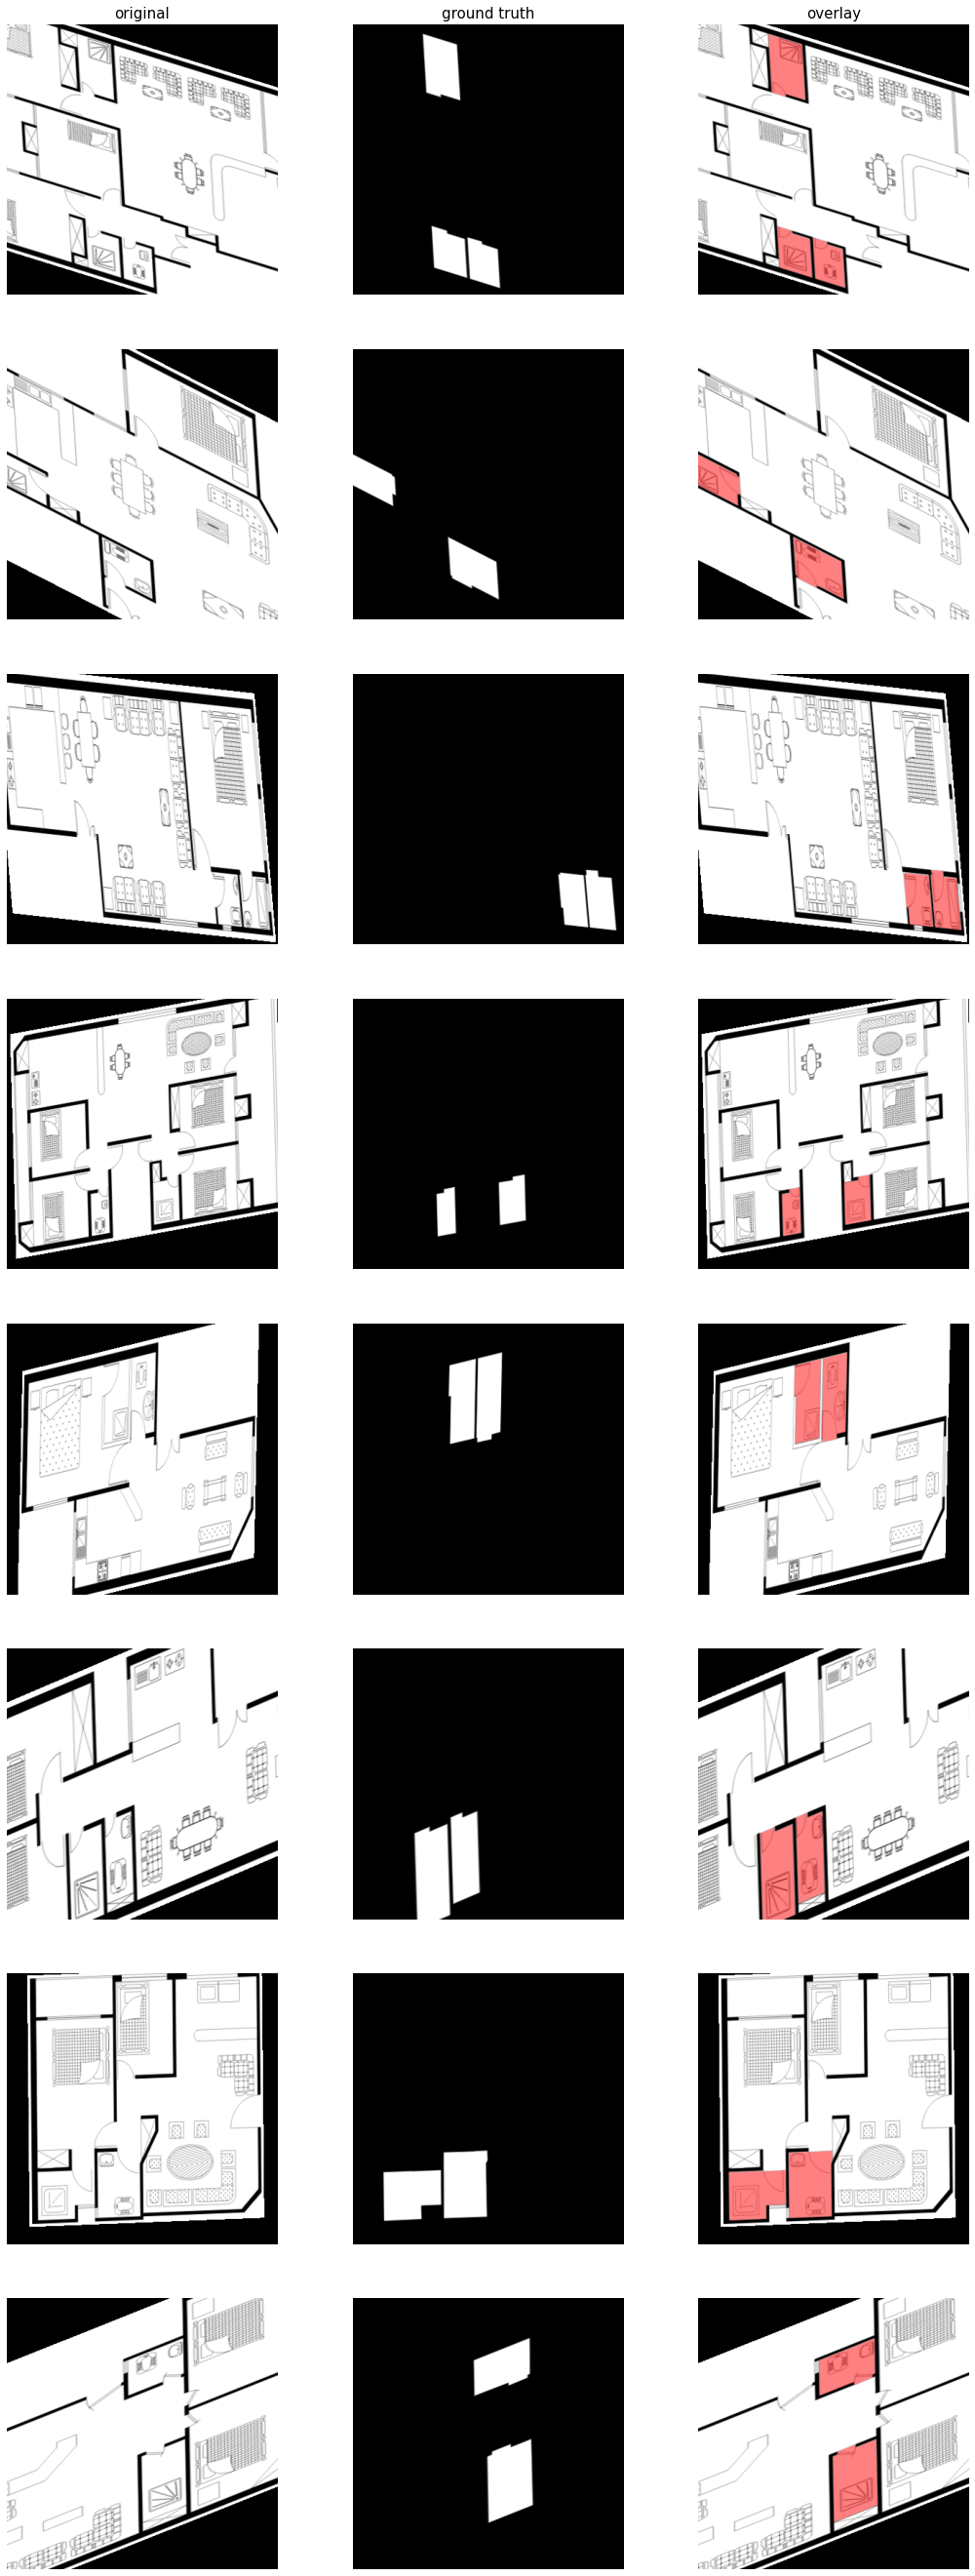

In [26]:
# Visualizing the generated output
plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=8, figsize=6)

In [20]:
# Model Definition
input_shape = x[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_classes=7,
    num_layers=2
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 384, 384, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 384, 384, 32) 128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_3 (SpatialDro (None, 384, 384, 32) 0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [21]:
# Define Model Checkpoint
model_filename = 'segm_model_data_new_mse_loss.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True
)

In [22]:
# Compile Model
model.compile(
    optimizer=Adam(), 
    loss=MeanSquaredError(),
    metrics=[iou]
)

In [25]:
# Needed for Tensorflow Version 2.0.0
train_gen = (pair for pair in train_gen)

In [26]:
# Train Model
history = model.fit(
    train_gen,
    validation_data=(x_val, y_val),
    steps_per_epoch=50,
    epochs=10,
    callbacks=[callback_checkpoint]
)

Train for 50 steps, validate on 5 samples
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.2150 - iou: 0.1406
Epoch 00001: val_loss improved from inf to 0.42369, saving model to segm_model_data_new_mse_loss.h5
50/50 [==============================] - 39s 774ms/step - loss: 0.2142 - iou: 0.1407 - val_loss: 0.4237 - val_iou: 0.0733
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.1567 - iou: 0.1556
Epoch 00002: val_loss improved from 0.42369 to 0.13327, saving model to segm_model_data_new_mse_loss.h5
50/50 [==============================] - 38s 762ms/step - loss: 0.1563 - iou: 0.1557 - val_loss: 0.1333 - val_iou: 0.1518
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.1226 - iou: 0.1663
Epoch 00003: val_loss improved from 0.13327 to 0.10233, saving model to segm_model_data_new_mse_loss.h5
50/50 [==============================] - 38s 757ms/step - loss: 0.1223 - iou: 0.1661 - val_loss: 0.1023 - val_iou: 0.1662
Epoch 4/10
49/50 

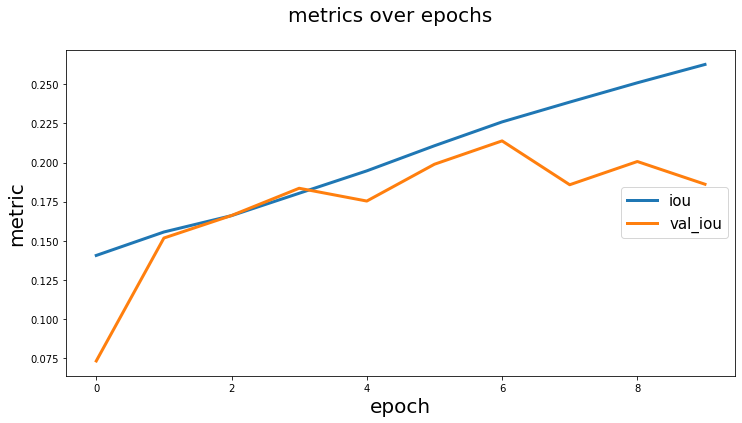

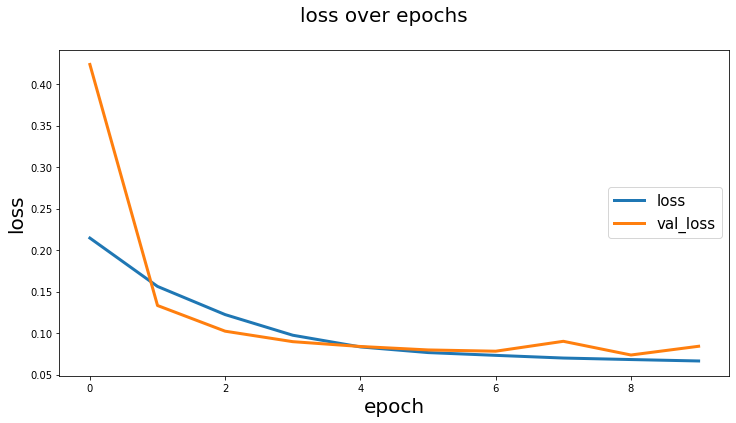

In [27]:
# Plot training History
plot_segm_history(history)

In [23]:
# Predict on Validation Set
model.load_weights(model_filename)
y_pred = model.predict(x_val)

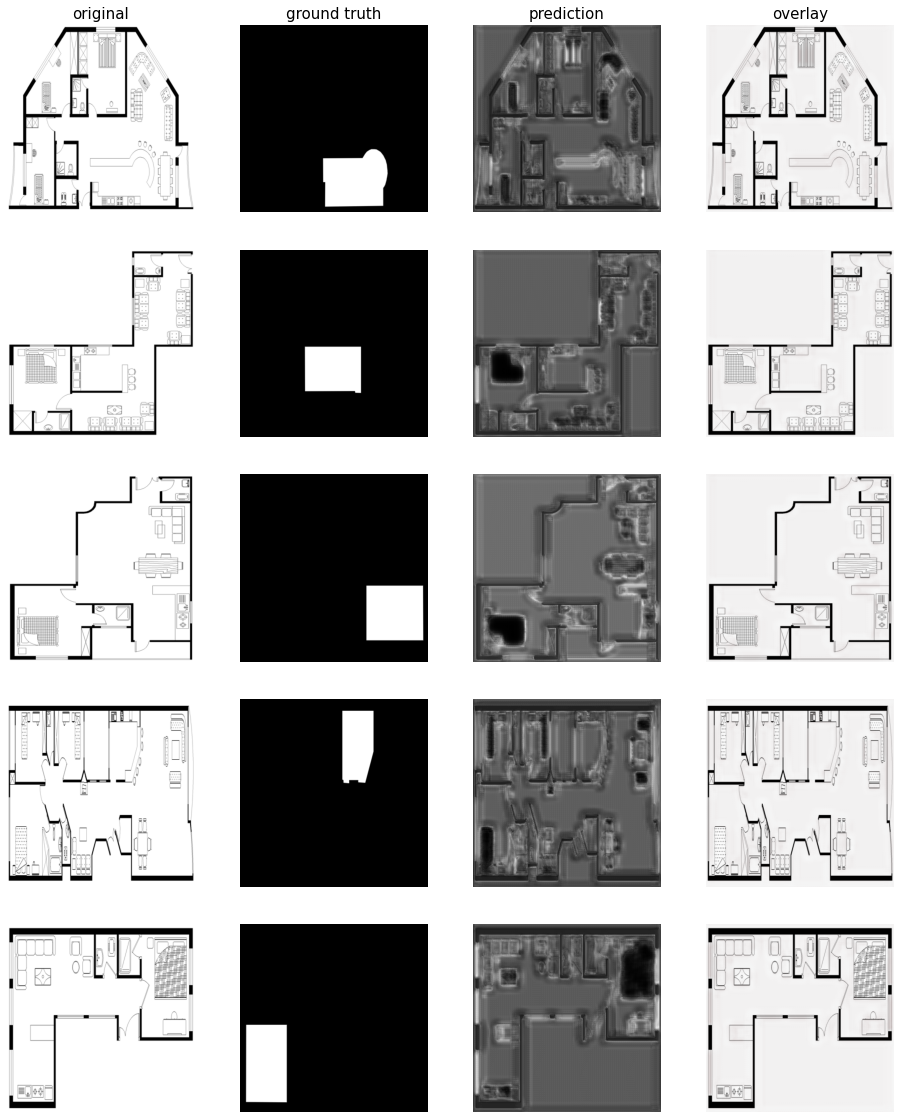

In [25]:
# Visualize Predictions
plot_imgs(org_imgs=x_val, mask_imgs=y_val[:,:,:,3], pred_imgs=y_pred[:,:,:,3], nm_img_to_plot=8)